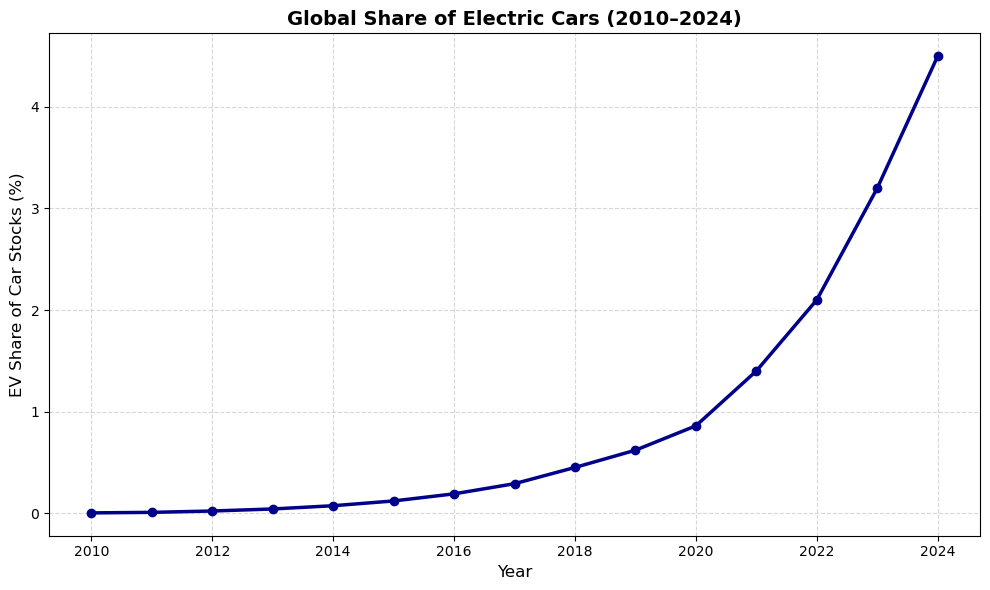

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# === Load dataset ===
file_path = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\share-car-stocks-electric\share-car-stocks-electric.csv"
df = pd.read_csv(file_path)

# === Filter only "World" and valid years ===
world = df[(df["Entity"] == "World") & (df["Year"].between(2010, 2024))].copy()
world["Year"] = pd.to_numeric(world["Year"], errors="coerce")
world["Share"] = pd.to_numeric(world["Share of car stocks that are electric"], errors="coerce")

# === Plot actual World trend ===
plt.figure(figsize=(10,6))
plt.plot(world["Year"], world["Share"], marker="o", color="darkblue", linewidth=2.5)

plt.title("Global Share of Electric Cars (2010–2024)", fontsize=14, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("EV Share of Car Stocks (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


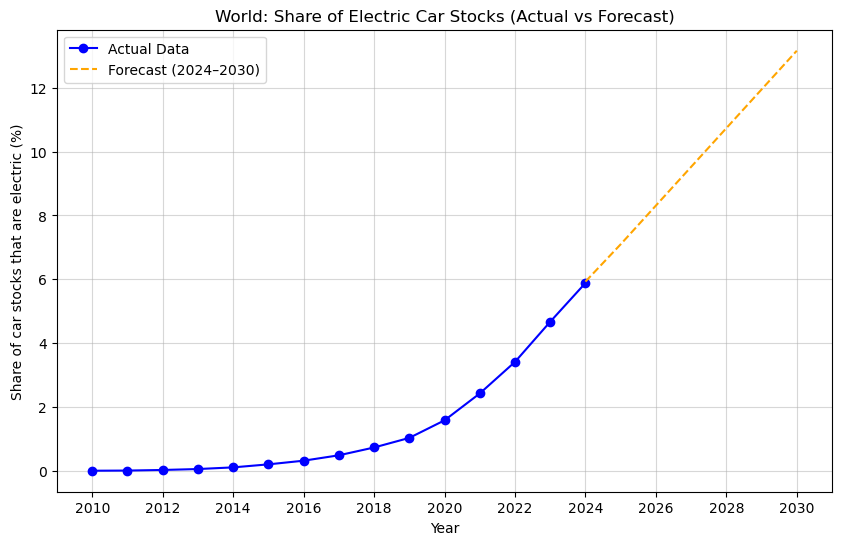

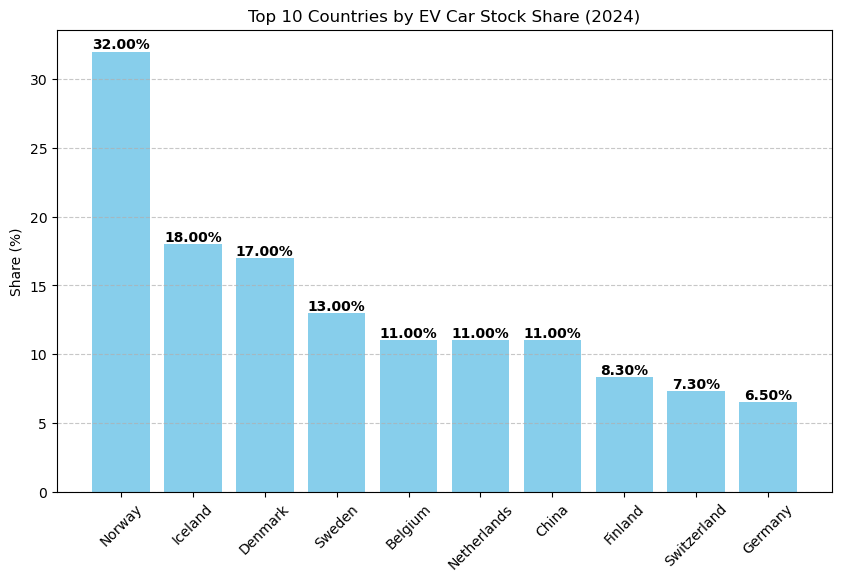

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# === Load dataset ===
file_path = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\share-car-stocks-electric\share-car-stocks-electric.csv"
df = pd.read_csv(file_path)

# Ensure numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Share of car stocks that are electric"] = pd.to_numeric(
    df["Share of car stocks that are electric"], errors="coerce"
)

# === WORLD AGGREGATE ===
world_df = df.groupby("Year")["Share of car stocks that are electric"].mean().reset_index()

# Fit Holt’s model
holt_model = ExponentialSmoothing(world_df["Share of car stocks that are electric"], trend="add", seasonal=None)
holt_fit = holt_model.fit()

# Forecast until 2030
forecast_start = world_df["Year"].max()
forecast_years = list(range(world_df["Year"].min(), 2031))
forecast = holt_fit.predict(start=0, end=len(forecast_years)-1)

# === Plot World with Forecast (from 2024) ===
plt.figure(figsize=(10,6))

# Actual data
plt.plot(world_df["Year"], world_df["Share of car stocks that are electric"],
         label="Actual Data", marker="o", color="blue")

# Forecast only from latest observed year onward
forecast_start_idx = forecast_start - world_df["Year"].min()
plt.plot(forecast_years[forecast_start_idx:], forecast[forecast_start_idx:],
         label="Forecast (2024–2030)", linestyle="--", color="orange")

# Format x-axis as integers
plt.xticks(range(world_df["Year"].min(), 2031, 2))  

plt.title("World: Share of Electric Car Stocks (Actual vs Forecast)")
plt.xlabel("Year")
plt.ylabel("Share of car stocks that are electric (%)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


# === TOP 10 COUNTRIES ===
latest_year = df["Year"].max()
latest_df = df[df["Year"] == latest_year]
latest_df = latest_df[latest_df["Code"].notna()]

# Get Top 10
top10 = latest_df.sort_values(by="Share of car stocks that are electric", ascending=False).head(10)

plt.figure(figsize=(10,6))
bars = plt.bar(top10["Entity"], top10["Share of car stocks that are electric"], color="skyblue")

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.2f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title(f"Top 10 Countries by EV Car Stock Share ({latest_year})")
plt.ylabel("Share (%)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


https://ourworldindata.org/grapher/share-car-stocks-electric?overlay=download-data

We used Holt’s Exponential Smoothing with a linear trend to forecast EV adoption. This method is ideal for annual data that shows a clear upward trend but no seasonality. Unlike simple curve extrapolation, Holt’s model updates based on recent years, balances trend with uncertainty, and provides confidence intervals. Given the relatively short time series, it offers a transparent and reliable baseline forecast, making the results easier to interpret and communicate.

In [ ]:
import pandas as pd

# Load dataset
file_path = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\share-car-stocks-electric\share-car-stocks-electric.csv"
df = pd.read_csv(file_path)

# Keep valid ISO codes
df = df[df["Code"].notna() & (df["Code"].str.len() == 3)].copy()
df["Share"] = pd.to_numeric(df["Share of car stocks that are electric"], errors="coerce")

# --- EARLY ADOPTERS: countries >5% before 2020 ---
early_candidates = df[df["Year"] < 2020].groupby("Entity")["Share"].max()
early_adopters = early_candidates[early_candidates >= 5].index.tolist()

# --- LATE MOVERS: countries <2% even in 2024 ---
late_candidates = df[df["Year"] == 2024][["Entity", "Share"]]
late_movers = late_candidates[late_candidates["Share"] < 2]["Entity"].tolist()

print("Early Adopters:", early_adopters)
print("Late Movers:", late_movers)


Early Adopters: ['Norway']
Late Movers: ['Australia', 'Brazil', 'Chile', 'Greece', 'India', 'Italy', 'Japan', 'Mexico', 'Poland', 'Spain', 'Turkey']


Year             CAGR     2015  2024
Entity                              
Brazil       1.246672  0.00048  0.70
Greece       0.968802  0.00270  1.20
Turkey       0.928188  0.00380  1.40
Mexico       0.801648  0.00150  0.30
Finland      0.749705  0.05400  8.30
Chile        0.690980  0.00230  0.26
New Zealand  0.685860  0.03000  3.30
Israel       0.677801  0.05600  5.90
Italy        0.668101  0.01500  1.50
Poland       0.652051  0.01200  1.10


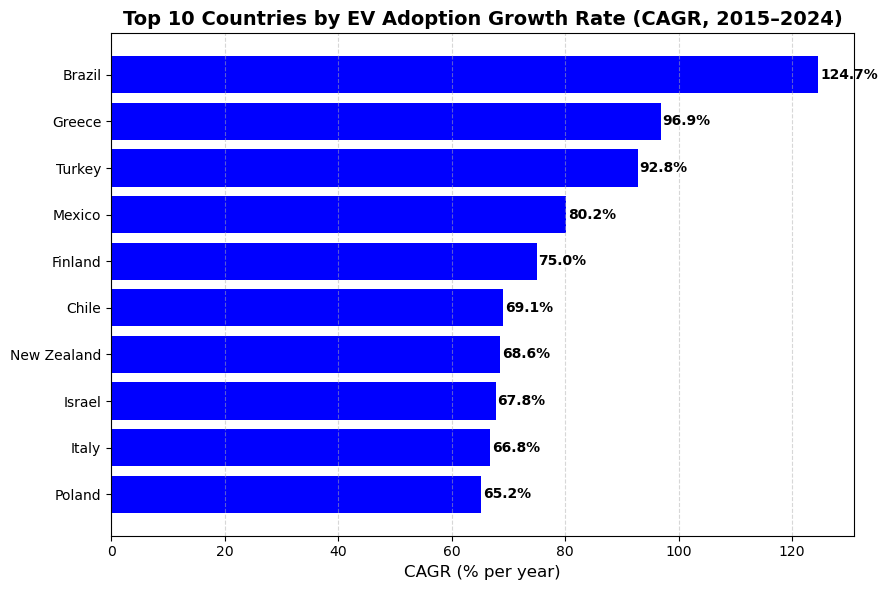

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\share-car-stocks-electric\share-car-stocks-electric.csv"
df = pd.read_csv(file_path)

# Keep valid ISO codes only
df = df[df["Code"].notna() & (df["Code"].str.len() == 3)].copy()
df["Share"] = pd.to_numeric(df["Share of car stocks that are electric"], errors="coerce")

# --- Filter 2015 and 2024 values ---
pivot = df.pivot(index="Entity", columns="Year", values="Share")

# Drop countries missing 2015 or 2024 data
pivot = pivot.dropna(subset=[2015, 2024])

# --- CAGR calculation ---
years = 2024 - 2015
pivot["CAGR"] = ((pivot[2024] / pivot[2015]) ** (1/years)) - 1

# --- Sort by CAGR ---
top10_cagr = pivot.sort_values("CAGR", ascending=False).head(10)
print(top10_cagr[["CAGR", 2015, 2024]])

# --- Plot ---
plt.figure(figsize=(9,6))
bars = plt.barh(top10_cagr.index, top10_cagr["CAGR"]*100, color="blue")
plt.title("Top 10 Countries by EV Adoption Growth Rate (CAGR, 2015–2024)", fontsize=14, weight="bold")
plt.xlabel("CAGR (% per year)", fontsize=12)
plt.gca().invert_yaxis()

# Add labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va="center", ha="left", fontsize=10, weight="bold")

plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


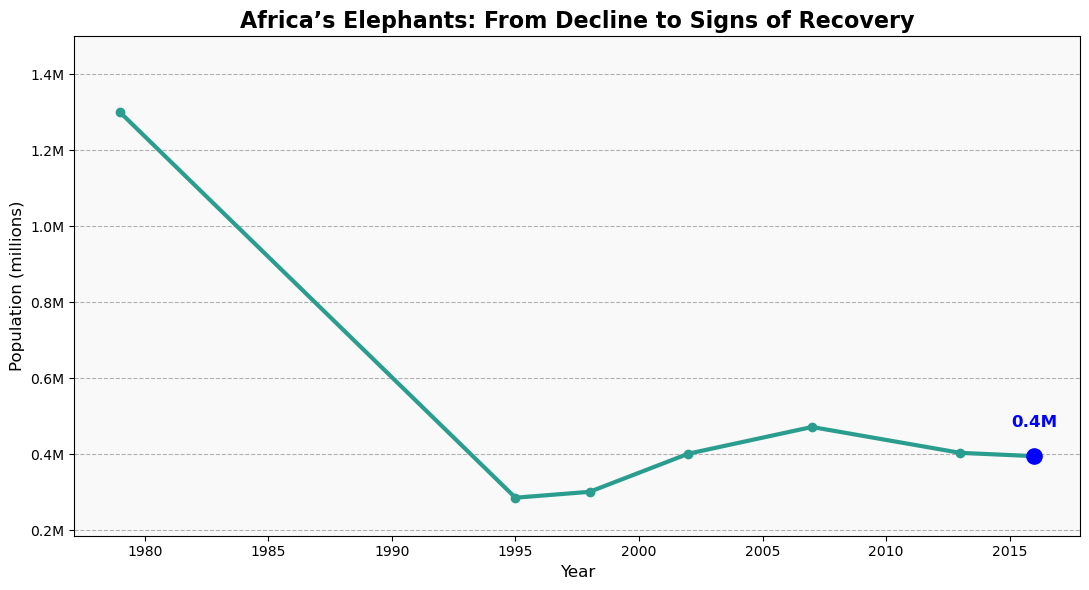

,Year,Elephants (millions)
0,1979,1.30
1,1995,0.29
2,1998,0.30
3,2002,0.40
4,2007,0.47
5,2013,0.40
6,2016,0.40


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# === Filter for Africa and sort ===
df = pd.read_csv(r"C:\Users\jincy\OneDrive\Desktop\TealProject\Datasets\african-elephants\african-elephants.csv")


# === Filter for Africa only and sort ===
africa_df = df[df["Entity"] == "Africa"].sort_values("Year").copy()
africa_df["Elephants (millions)"] = africa_df["Number of African elephants"] / 1_000_000

# Identify the most recent year
recent = africa_df.iloc[-1]

# === Plot ===
plt.figure(figsize=(11,6))
ax = plt.gca()

# Light background
ax.set_facecolor("#f9f9f9")

# Line + markers
plt.plot(africa_df["Year"], africa_df["Elephants (millions)"],
         marker="o", markersize=6, linewidth=3, color="#2a9d8f")

# Format y-axis to show in millions with M
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}M"))

# Title & labels
plt.title("Africa’s Elephants: From Decline to Signs of Recovery", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Population (millions)", fontsize=12)

# Horizontal dashed grid lines
plt.grid(axis="y", linestyle="--", alpha=0.6, color="grey")

# Expand y-limits slightly to fit label
ymin, ymax = africa_df["Elephants (millions)"].min(), africa_df["Elephants (millions)"].max()
plt.ylim(ymin - 0.1, ymax + 0.2)

# === Highlight only latest point ===
plt.scatter(recent["Year"], recent["Elephants (millions)"], color="blue", s=120, zorder=5)

# Label only the latest point (just value)
plt.text(recent["Year"], recent["Elephants (millions)"]+0.07,
         f"{recent['Elephants (millions)']:.1f}M",
         ha="center", va="bottom", fontsize=12, fontweight="bold", color="blue")

plt.tight_layout()
plt.show()

# === Table for blog transparency ===
display_table = africa_df[["Year", "Elephants (millions)"]].copy()
display_table["Elephants (millions)"] = display_table["Elephants (millions)"].round(2)
display_table



